# ADPD Subset Peaks

Given a subset of peaks, find out which pseudobulk samples in Alzheimer's Parkinsons datasets (processed by Anna) have highest/lowest fraction of reads/normalized reads in those peaks.

**STATUS** : Results unstable

<img src="figs/ADPD.png">

In [1]:
library(GenomicRanges)
library(DESeq2)

In [105]:
# load encode counts matrix
gz = gzfile("/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/pseudobulk/count_matrix_overlap/adpd.pseudobulk.overlap.atac.counts.txt.gz", 'rt')
# gz = gzfile("/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/pseudobulk/count_matrix_idr/adpd.pseudobulk.idr.atac.counts.txt.gz", 'rt')
cts <- read.csv(gz, sep="\t")
rownames(cts)=paste(cts$chrom,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,Cluster10,Cluster11,Cluster12,Cluster13,Cluster14,Cluster15,Cluster16,Cluster17,Cluster18,Cluster19,⋯,Cluster23,Cluster24,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 9944 10545,24,77,36,20,86,77,10,8,8,58,⋯,39,146,334,72,37,16,24,32,8,112
chr1 17391 17612,2,49,6,4,11,14,1,2,6,10,⋯,5,8,36,16,19,4,3,9,2,19


[1] 610538     24

In [106]:
adpd_peaks_gr = GRanges(sub("\t", "-", sub("\t", ":", rownames(cts))))

In [107]:
head(adpd_peaks_gr)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames        ranges strand
         <Rle>     <IRanges>  <Rle>
  [1]     chr1    9944-10545      *
  [2]     chr1   17391-17612      *
  [3]     chr1   29204-29511      *
  [4]     chr1   91253-91453      *
  [5]     chr1 180688-181242      *
  [6]     chr1 181334-181595      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [108]:
# norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<50)==0,]))

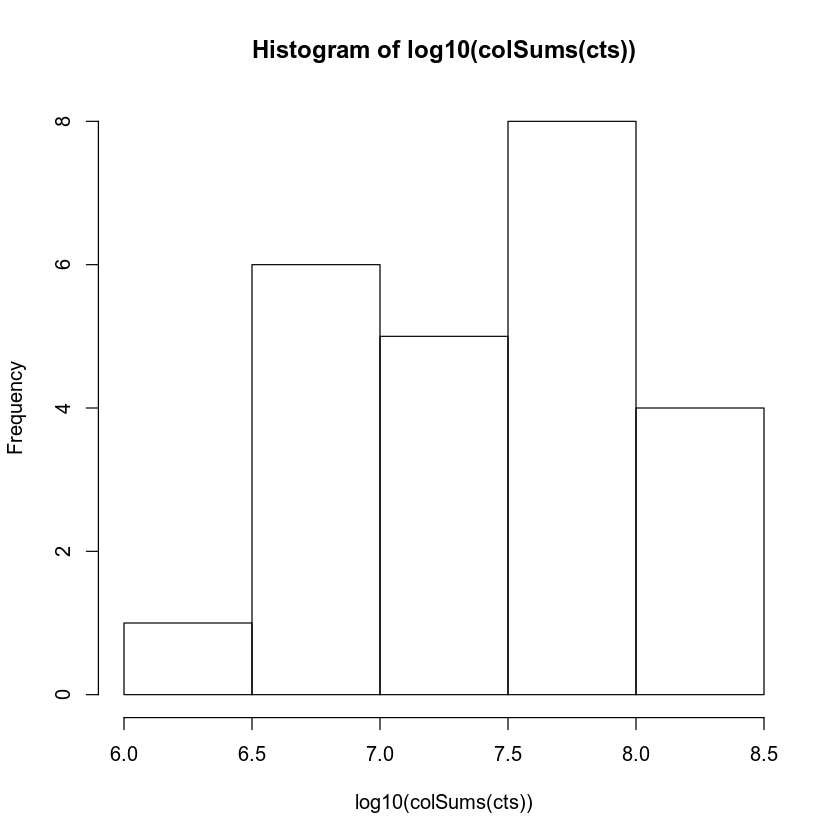

In [109]:
hist(log10(colSums(cts)))

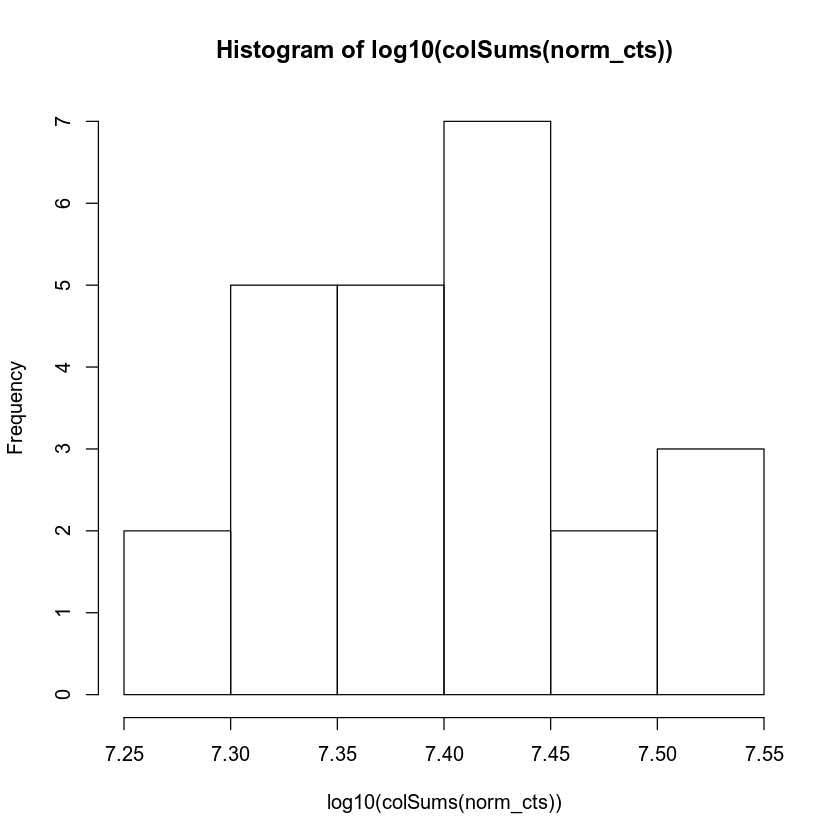

In [110]:
hist(log10(colSums(norm_cts)))

In [111]:
# ref peaks
peak_set = read.table("./beds/20200307_gridmap_naive_n15/idx8.bed",
                      header=F, sep='')
colnames(peak_set) = c("chr", "start", "end")
peak_set = makeGRangesFromDataFrame(peak_set)
head(peak_set)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr1 1094825-1095170      *
  [2]     chr1 1191662-1192082      *
  [3]     chr1 1222306-1222544      *
  [4]     chr1 1261227-1261590      *
  [5]     chr1 1421667-1421867      *
  [6]     chr1 1557055-1557256      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [112]:
overlaps = findOverlaps(adpd_peaks_gr, peak_set)
overlaps

Hits object with 6885 hits and 0 metadata columns:
         queryHits subjectHits
         <integer>   <integer>
     [1]       116           1
     [2]       357           9
     [3]       358           9
     [4]       359           9
     [5]       868          13
     ...       ...         ...
  [6881]    609952       26937
  [6882]    609953       26938
  [6883]    610404       26958
  [6884]    610405       26958
  [6885]    610451       26966
  -------
  queryLength: 610538 / subjectLength: 26967

In [113]:
length(unique(queryHits(overlaps)))

[1] 6705

In [114]:
frac_reads_in_peak_set = colSums(cts[unique(queryHits(overlaps)),])/colSums(cts)
norm_reads_in_peak_set = colSums(norm_cts[unique(queryHits(overlaps)),])

In [115]:
df = data.frame(nrip=norm_reads_in_peak_set,
               sample=colnames(cts),
               totcounts=colSums(cts))
df = df[rev(order(df$nrip)), ]
df

,nrip,sample,totcounts
,<dbl>,<fct>,<dbl>
Cluster4,311413.0,Cluster4,34007176
Cluster3,307859.1,Cluster3,29233406
Cluster2,287565.2,Cluster2,149778795
Cluster5,258344.4,Cluster5,7528672
Cluster1,246660.4,Cluster1,171039753
Cluster19,242840.2,Cluster19,41536286
Cluster23,239868.4,Cluster23,17106102
Cluster7,230267.8,Cluster7,21625814
Cluster6,223498.2,Cluster6,9589399


In [116]:
df = data.frame(percentage=100*frac_reads_in_peak_set,
               sample=colnames(cts))
df = df[rev(order(df$percentage)), ]
df

,percentage,sample
,<dbl>,<fct>
Cluster2,1.0156504,Cluster2
Cluster19,0.9633264,Cluster19
Cluster23,0.9472877,Cluster23
Cluster21,0.9377994,Cluster21
Cluster7,0.8967339,Cluster7
Cluster20,0.8950260,Cluster20
Cluster3,0.8915075,Cluster3
Cluster4,0.8863570,Cluster4
Cluster22,0.8366444,Cluster22
